Feature extraction is a process to extract important features from data. It includes identifying linguistic data and avoiding any kind of noise. Audio features are classified into 3 categories high-level, mid-level, and low-level audio features.

High-level features are related to music lyrics like chords, rhythm, melody, etc.

Mid-level features include beat level attributes, pitch-like fluctuation patterns, and MFCCs.

Low-level features include energy, a zero-crossing rate which are statistical measures that get extracted from audio during feature extraction. So to generate these features we use a certain set of steps and are combined under a single name as MFCC that helps extract mid-level and low-level audio features. below are the steps discussed for the working of MFCCs in feature extraction.

Audio files are of a certain length(duration) in seconds or as long as in minutes. And the pitch or frequency is continuously changing so to understand this we first divide the audio file into small-small frames which are near about 20 to 40 ms long.
After dividing into frames we try to identify and extract different frequencies from each frame. When we divide in such a small frame so assume that one frame divides down in a single frequency. separate linguistic frequencies from the noise
To discard any type of noise, take discrete cosine transform (DCT) of the frequencies.

### Load libraries

In [1]:
import UrbanSound8K_dataprep as U
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import librosa
from sklearn.model_selection import train_test_split
import os

### Parameters

In [2]:
# general parameters
PATH = "data/UrbanSound8K"

### Instantiate the Dataset object
get the training and validations sets with kfold=1

In [3]:
dataset_train = U.UrbanSoundPrep(PATH, fold=1, train=True)
dataset_val = U.UrbanSoundPrep(PATH, fold=1, train=False)

### Load metadata

In [4]:
df = dataset_train.metadata
labels = dataset_train.class_mapping
labels

{'air_conditioner': 0,
 'car_horn': 1,
 'children_playing': 2,
 'dog_bark': 3,
 'drilling': 4,
 'engine_idling': 5,
 'gun_shot': 6,
 'jackhammer': 7,
 'siren': 8,
 'street_music': 9}

### Data exploration

In [5]:
length_train = len(dataset_train)
length_train

7859

In [6]:
length_val = len(dataset_val)
length_val

873

In [7]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [8]:
class_percentage_train = (df['class'].value_counts() / length_train) * 100
class_percentage_train

engine_idling       11.502736
dog_bark            11.451839
children_playing    11.451839
air_conditioner     11.451839
street_music        11.451839
drilling            11.451839
jackhammer          11.197353
siren               10.726556
car_horn             5.000636
gun_shot             4.313526
Name: class, dtype: float64

In [9]:
df['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'siren', 'engine_idling', 'drilling', 'jackhammer',
       'gun_shot'], dtype=object)

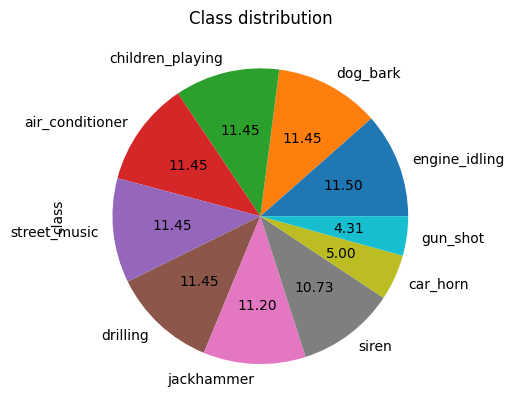

In [10]:
df['class'].value_counts().plot.pie(autopct='%.2f')
plt.title("Class distribution")
plt.savefig("figures/USD-class_distribution.png", bbox_inches='tight')

In [11]:
df['durations'] = df['end'] - df['start']
df

,slice_file_name,fsID,start,end,salience,fold,classID,class,durations
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,0.317551
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,4.000000
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,4.000000
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,4.000000
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,4.000000
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,4.000000
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,2.532098


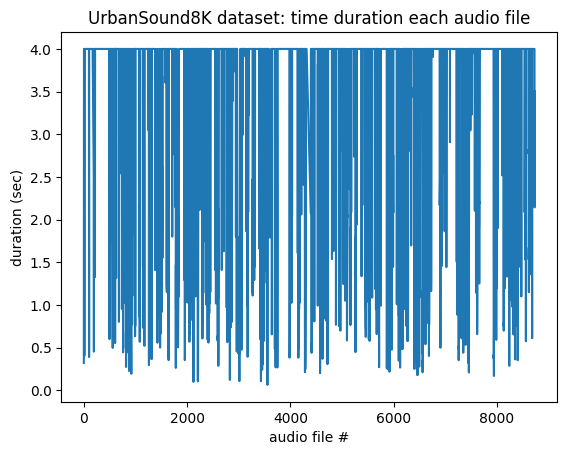

In [12]:
df.durations.plot()
plt.xlabel("audio file #")
plt.ylabel("duration (sec)")
plt.title("UrbanSound8K dataset: time duration each audio file")
plt.savefig("figures/USD-durations.png", bbox_inches='tight')

In [13]:
df['durations'].describe()

count    7859.000000
mean        3.605639
std         0.975204
min         0.061579
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: durations, dtype: float64

In [14]:
df_short = df[df['durations'] < 4]
df_short

,slice_file_name,fsID,start,end,salience,fold,classID,class,durations
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,0.317551
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn,0.648525
10,100648-1-1-0.wav,100648,8.998279,10.052132,2,10,1,car_horn,1.053853
11,100648-1-2-0.wav,100648,16.699509,17.104837,2,10,1,car_horn,0.405328
12,100648-1-3-0.wav,100648,17.631764,19.253075,2,10,1,car_horn,1.621311
...,...,...,...,...,...,...,...,...,...
8681,99185-3-0-0.wav,99185,0.341411,0.950911,1,5,3,dog_bark,0.609500
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,2.142545
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,3.505983
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,2.532098


### Check if all files have the same sample rate

In [15]:
sample_rates = []
number_of_channels = []
number_of_samples = []
for i in range(0,length_train):
    waveform, sample_rate, label = dataset_train[i]
    
    number_of_channels.append(waveform.shape[0])
    number_of_samples.append(waveform.shape[1])
    sample_rates.append(sample_rate)    

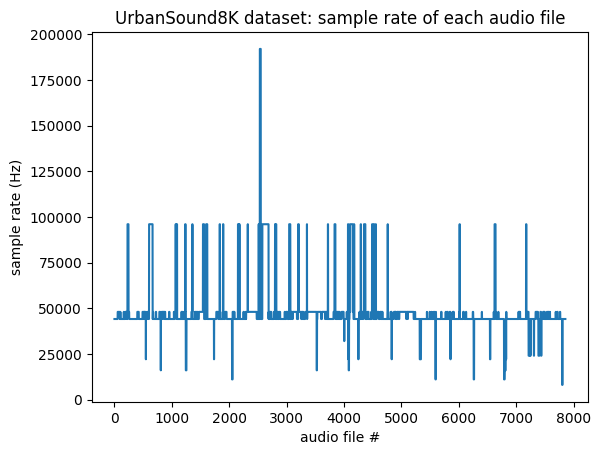

In [16]:
plt.figure()
plt.plot(sample_rates)
plt.xlabel("audio file #")
plt.ylabel("sample rate (Hz)")
plt.title("UrbanSound8K dataset: sample rate of each audio file")
plt.savefig("figures/USD-sample_rates.png", bbox_inches='tight')

In [17]:
np.mean(sample_rates)

48146.8753022013

In [18]:
min(sample_rates)

8000

In [19]:
max(sample_rates)

192000

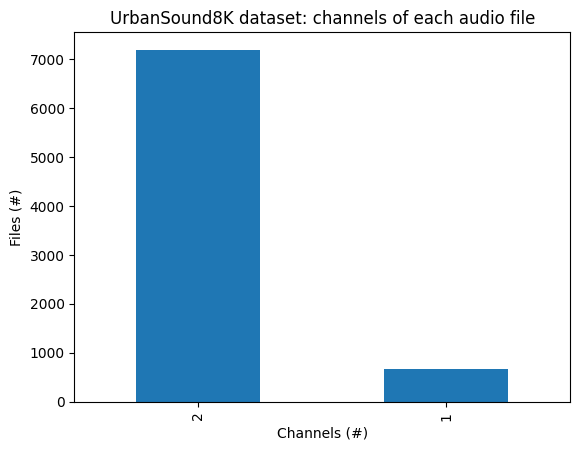

In [20]:
number_of_channels_df = pd.DataFrame()
number_of_channels_df['channels'] = number_of_channels
number_of_channels_df['channels'].value_counts().plot.bar()
plt.xlabel("Channels (#)")
plt.ylabel("Files (#)")

plt.title("UrbanSound8K dataset: channels of each audio file")
plt.savefig("figures/USD-number_of_channels.png", bbox_inches='tight')

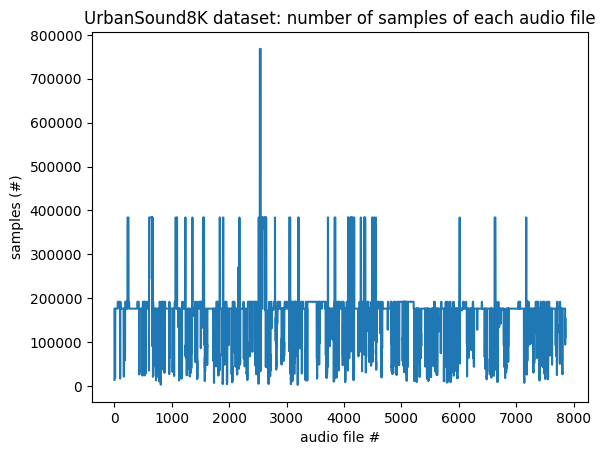

In [21]:
plt.figure()
plt.plot(number_of_samples)
plt.xlabel("audio file #")
plt.ylabel("samples (#)")
plt.title("UrbanSound8K dataset: number of samples of each audio file")
plt.savefig("figures/USD-number_of_samples.png", bbox_inches='tight')

In [22]:
waveform, sample_rate, label = dataset_train[1]

In [23]:
num_channels, samples = waveform.shape
num_channels

2

In [24]:
samples

176400

### Check process pipeline when down-sampling

In [25]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

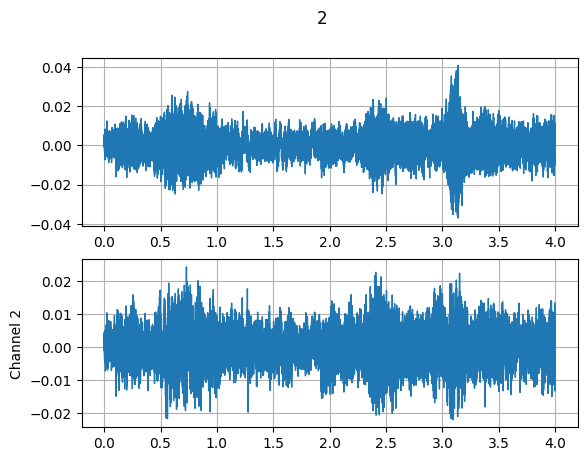

In [26]:
dataset_train = U.UrbanSoundPrep(PATH, fold=1, train=True, preprocess=False)
waveform, sample_rate, label =  dataset_train[1]
plot_waveform(waveform, sample_rate, label)

In [27]:
print("Raw waveform")
print("The sample_rate is : {} and the number of samples is: {}".format(sample_rate, waveform.shape[1]))

Raw waveform
The sample_rate is : 44100 and the number of samples is: 176400


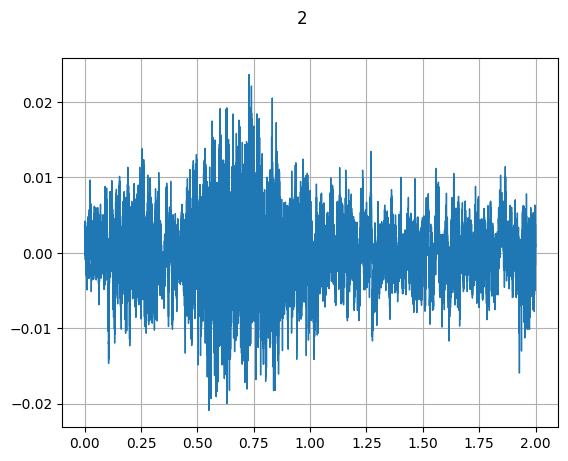

In [28]:
dataset_train = U.UrbanSoundPrep(PATH, fold=1, train=True, preprocess=True, resample_rate=44100, number_of_samples=88200)
waveform, sample_rate, label =  dataset_train[1]
plot_waveform(waveform, sample_rate, label)

In [29]:
print("Processed waveform")
print("The sample_rate is : {} and the number of samples is: {}".format(sample_rate, waveform.shape[1]))

Processed waveform
The sample_rate is : 44100 and the number of samples is: 88200


### Check process pipeline when up-sampling

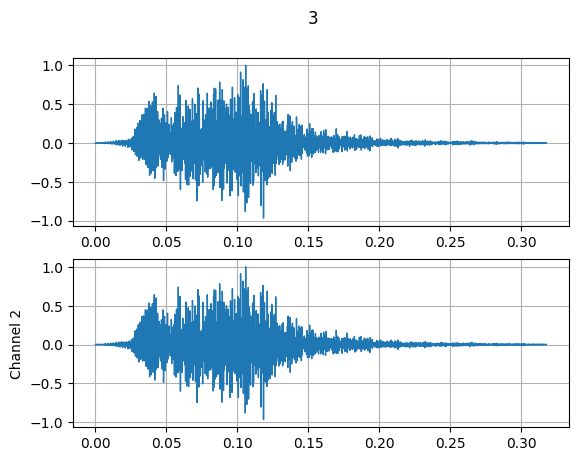

In [30]:
dataset_train = U.UrbanSoundPrep(PATH, fold=1, train=True, preprocess=False)
waveform, sample_rate, label =  dataset_train[0]
plot_waveform(waveform, sample_rate, label)

In [31]:
print("Processed waveform")
print("The sample_rate is : {} and the number of samples is: {}".format(sample_rate, waveform.shape[1]))

Processed waveform
The sample_rate is : 44100 and the number of samples is: 14004


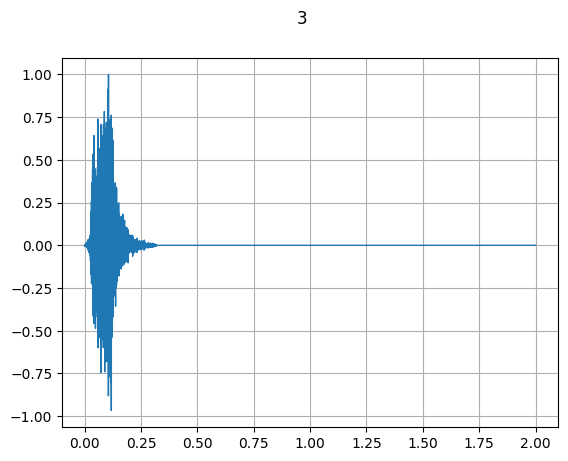

In [32]:
dataset_train = U.UrbanSoundPrep(PATH, fold=1, train=True, preprocess=True, resample_rate=44100, number_of_samples=88200)
waveform, sample_rate, label =  dataset_train[0]
plot_waveform(waveform, sample_rate, label)

In [33]:
print("Processed waveform")
print("The sample_rate is : {} and the number of samples is: {}".format(sample_rate, waveform.shape[1]))

Processed waveform
The sample_rate is : 44100 and the number of samples is: 88200


## Visualize the features

In [34]:
FOLD = 1
RESAMPLE_RATE = 44100
NUMBER_OF_SAMPLES = 66150

In [35]:
def plot_waveform(waveform, sample_rate, label):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    
    figure = plt.figure(figsize=(16,2))
    
    plt.plot(time_axis, waveform[0])
    key = [k for k, v in labels.items() if v == label]
    plt.title(key)
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude (a.u.)')

In [36]:
dataset_train_waves = U.UrbanSoundPrep(PATH, fold=FOLD, train=True, preprocess=False)
df = dataset_train_waves.metadata
df.reset_index()

,index,slice_file_name,fsID,start,end,salience,fold,classID,class
0,0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...,...
7854,8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
7855,8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
7856,8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
7857,8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


### Unprocessed raw waveforms

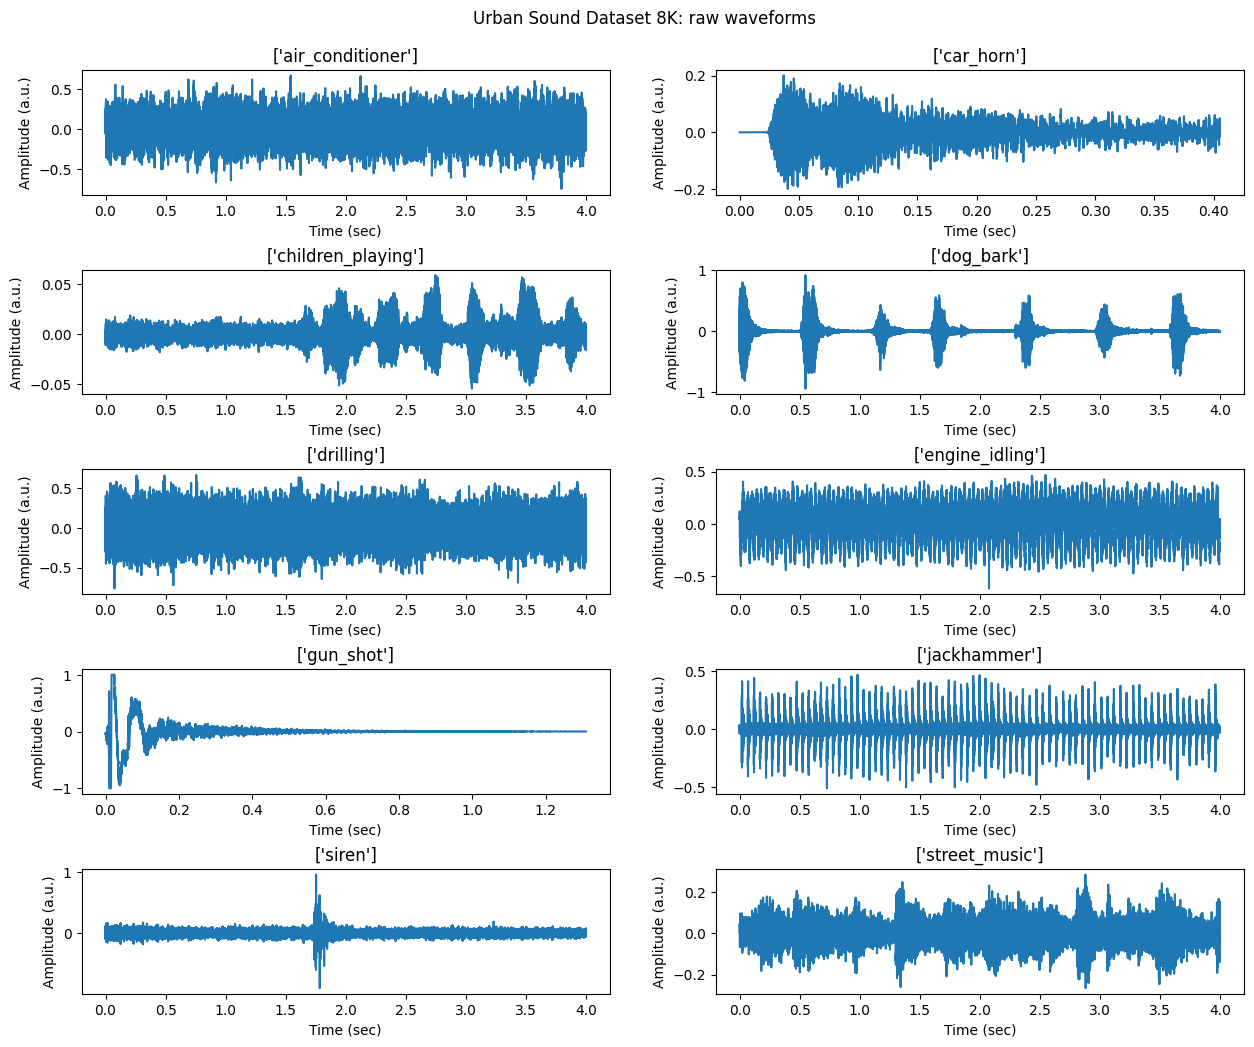

In [37]:
dataset_train_waves = U.UrbanSoundPrep(PATH, fold=FOLD, train=True, preprocess=False)
df = dataset_train_waves.metadata
df = df.reset_index()

labels = dataset_train_waves.class_mapping

sample_idx = 2
n_rows = int((len(labels.keys()) / 2))

fig, axs = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.6)
fig.suptitle("Urban Sound Dataset 8K: raw waveforms", y=0.93)

for label, ax in zip(labels.keys(), axs.ravel()):
    index = df.index[df['class']==label].tolist()
    waveform, sample_rate, label = dataset_train_waves[index[sample_idx]]
    
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    ax.plot(time_axis, waveform[0])
    key = [k for k, v in labels.items() if v == label]
    ax.set_title(key)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude (a.u.)')

plt.savefig("figures/USD-unprocessed_raw_waveforms.png", bbox_inches='tight')

### Processed waveforms

In [38]:
dataset_train_waves = U.UrbanSoundPrep(PATH, 
                                 fold = FOLD,
                                 preprocess=True, 
                                 resample_rate=RESAMPLE_RATE, 
                                 number_of_samples=NUMBER_OF_SAMPLES)
df = dataset_train_waves.metadata
df = df.reset_index()

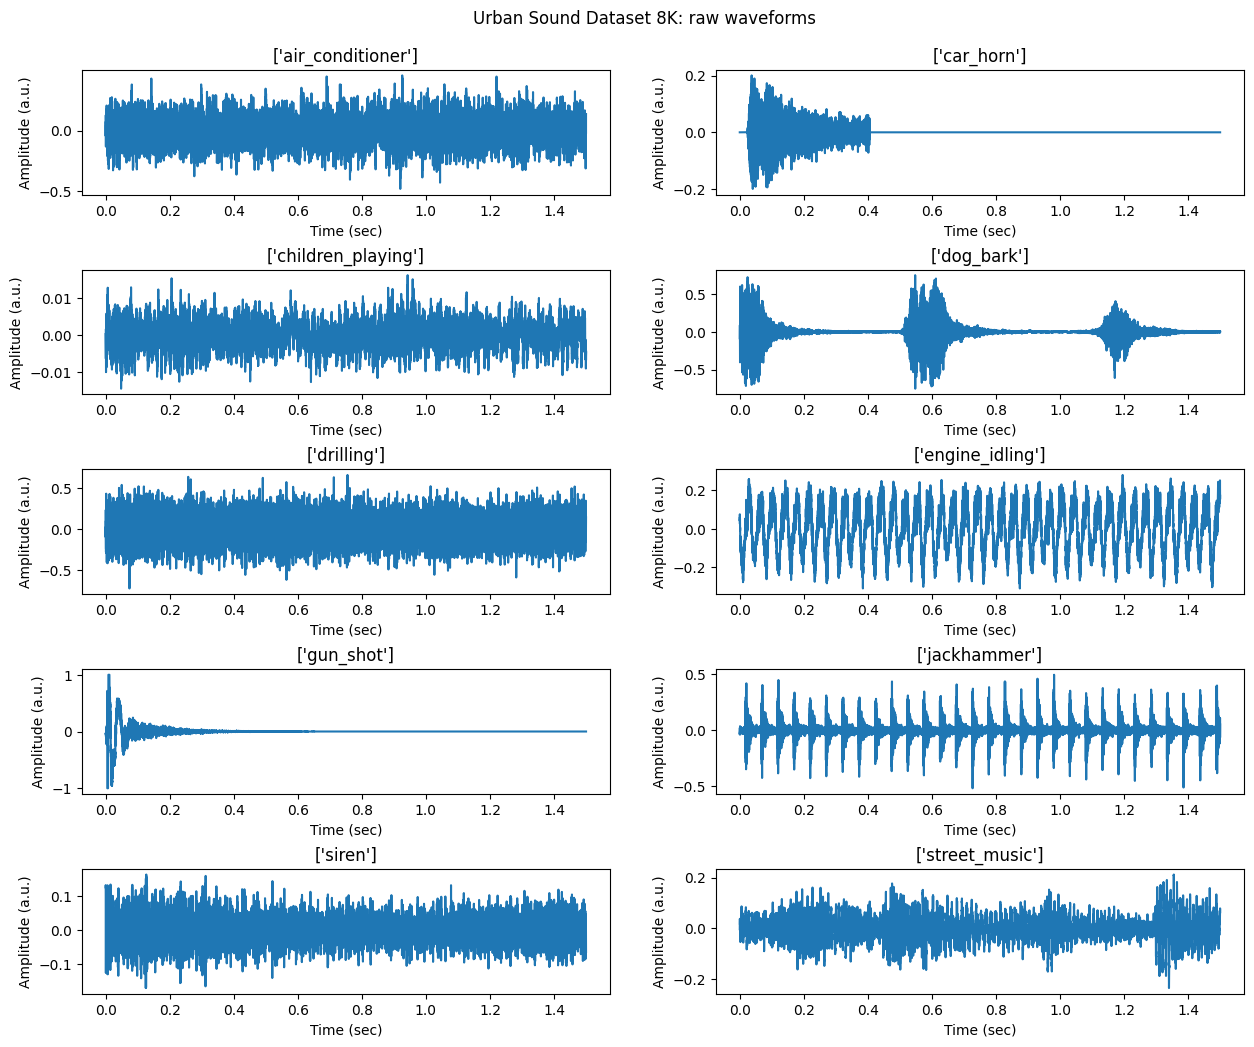

In [39]:
labels = dataset_train_waves.class_mapping

sample_idx = 2
n_rows = int((len(labels.keys()) / 2))

fig, axs = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.6)
fig.suptitle("Urban Sound Dataset 8K: raw waveforms", y=0.93)

for label, ax in zip(labels.keys(), axs.ravel()):
    index = df.index[df['class']==label].tolist()
    waveform, sample_rate, label = dataset_train_waves[index[sample_idx]]
    
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    ax.plot(time_axis, waveform[0])
    key = [k for k, v in labels.items() if v == label]
    ax.set_title(key)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude (a.u.)')

plt.savefig("figures/USD-processed_waveforms.png", bbox_inches='tight')

## Plot Melspectrograms

In [40]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 64

mel_spectrogram = T.MelSpectrogram(
    sample_rate=RESAMPLE_RATE,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

dataset_melspecs = U.UrbanSoundPrep(PATH, 
                                    fold=FOLD, 
                                    preprocess=True, 
                                    transform=mel_spectrogram, 
                                    resample_rate=RESAMPLE_RATE, 
                                    number_of_samples=NUMBER_OF_SAMPLES)

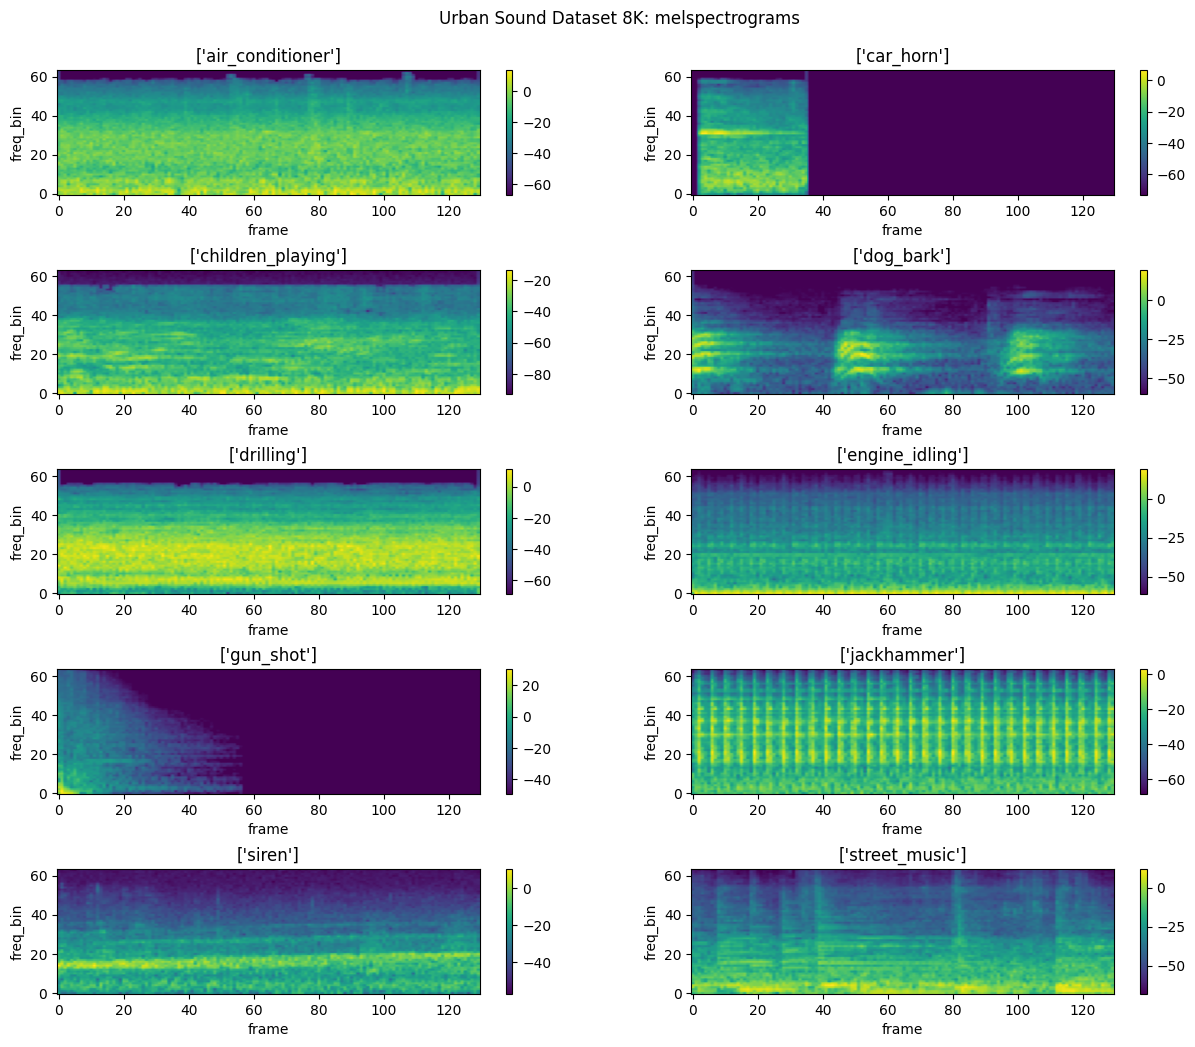

In [41]:
sample_idx = 2
n_rows = int((len(labels.keys()) / 2))

fig, axs = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.6)
fig.suptitle("Urban Sound Dataset 8K: melspectrograms", y=0.93)

for label, ax in zip(labels.keys(), axs.ravel()):
    index = df.index[df['class']==label].tolist()
    waveform, sample_rate, label = dataset_melspecs[index[sample_idx]]
    
    im = ax.imshow(librosa.power_to_db(waveform[0]), origin="lower", aspect="auto")
    fig.colorbar(im, ax=ax)
#     plt.show(block=False)
    key = [k for k, v in labels.items() if v == label]
    ax.set_title(key)
    ax.set_xlabel('frame')
    ax.set_ylabel('freq_bin')
    
plt.savefig("figures/USD-processed_melspecs.png", bbox_inches='tight')

## Plot MFCCs


In [42]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 128
n_mfcc = 13

mfcc_transform = T.MFCC(
    sample_rate=RESAMPLE_RATE,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

dataset_mfcc = U.UrbanSoundPrep(PATH, 
                                fold=FOLD,
                                preprocess=True, 
                                transform=mfcc_transform, 
                                resample_rate=RESAMPLE_RATE, 
                                number_of_samples=NUMBER_OF_SAMPLES)

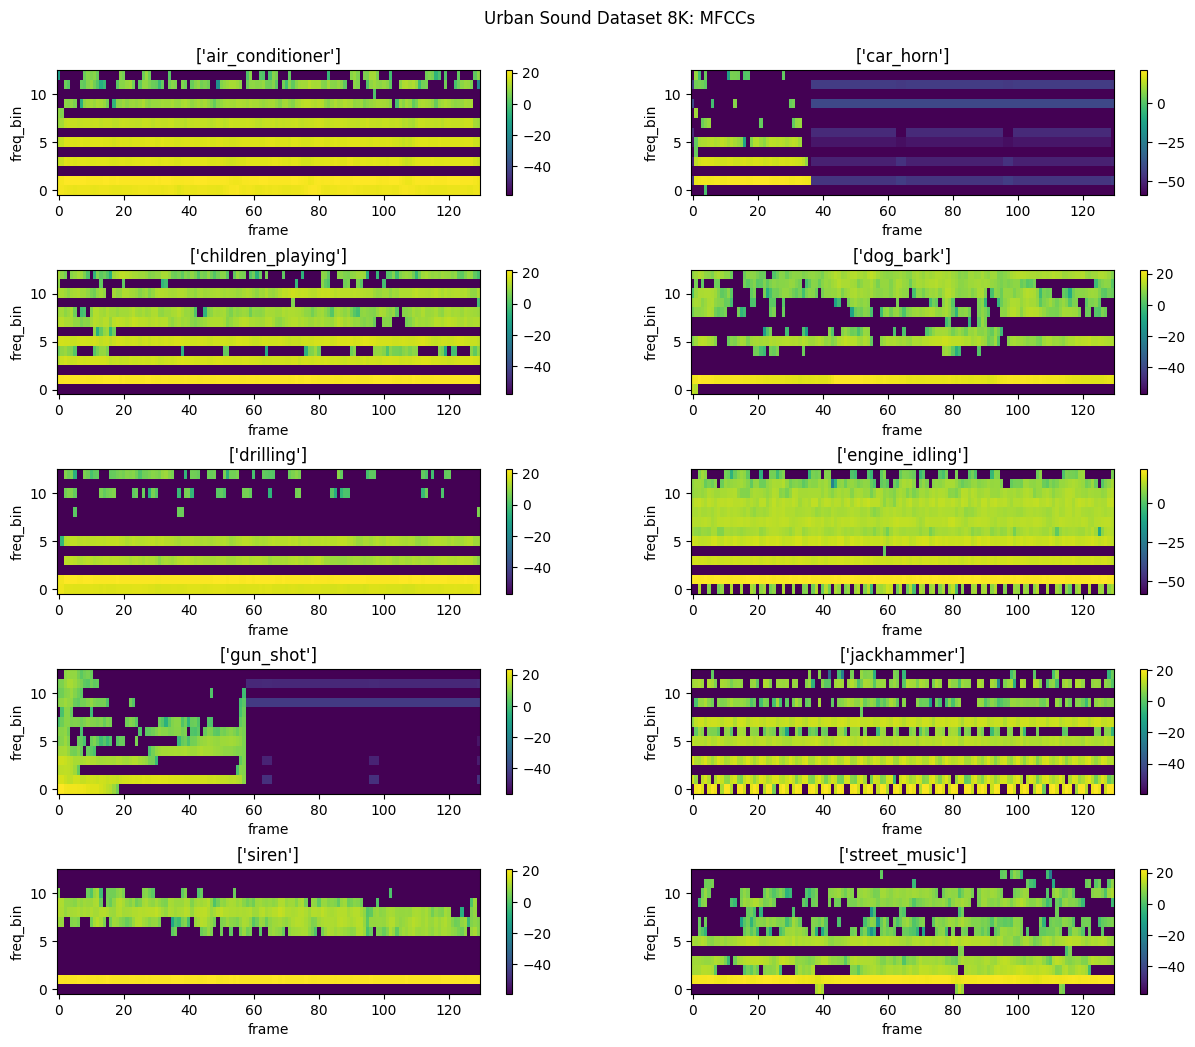

In [43]:
sample_idx = 2
n_rows = int((len(labels.keys()) / 2))

fig, axs = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.6)
fig.suptitle("Urban Sound Dataset 8K: MFCCs", y=0.93)

for label, ax in zip(labels.keys(), axs.ravel()):
    index = df.index[df['class']==label].tolist()
    waveform, sample_rate, label = dataset_mfcc[index[sample_idx]]
    
    im = ax.imshow(librosa.power_to_db(waveform[0]), origin="lower", aspect="auto")
    fig.colorbar(im, ax=ax)
#     plt.show(block=False)
    key = [k for k, v in labels.items() if v == label]
    ax.set_title(key)
    ax.set_xlabel('frame')
    ax.set_ylabel('freq_bin')
    
plt.savefig("figures/USDprocessed_mfcc.png", bbox_inches='tight')

### save datasets

In [44]:
def create_dirs(path, fold, transform):
    fold_path = os.path.join(PATH, transform, f"fold{fold}/train")
    os.makedirs(fold_path, exist_ok=True)

    fold_path = os.path.join(PATH, transform, f"fold{fold}/val")
    os.makedirs(fold_path, exist_ok=True)

In [45]:
def save_tensors(path, fold, train, transform, name):
    
    dataset = U.UrbanSoundPrep(path, 
                               fold=fold, 
                               train=train, 
                               preprocess=True, 
                               transform=transform, 
                               resample_rate=RESAMPLE_RATE, 
                               number_of_samples=NUMBER_OF_SAMPLES)
    
    if train:
        fold_path = os.path.join(path, name, f"fold{FOLD}/train")
    else:
        fold_path = os.path.join(path, name, f"fold{FOLD}/val")
    for idx, tensor in enumerate(dataset):
        tensor_path = os.path.join(fold_path, f"{name}{idx}.pt")
        torch.save(tensor, tensor_path)

#### MFCC

In [46]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 128
n_mfcc = 13

mfcc_transform = T.MFCC(
    sample_rate=RESAMPLE_RATE,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)
create_dirs(PATH, 1, "mfcc" )
save_tensors(PATH, 1, True, mfcc_transform, 'mfcc') # test set - fold = 1
save_tensors(PATH, 1, False, mfcc_transform, 'mfcc') # val set - fold = 1

#### Melspectrograms

In [47]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 64

mel_spectrogram = T.MelSpectrogram(
    sample_rate=RESAMPLE_RATE,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)


create_dirs(PATH, 1, "melspec" )
save_tensors(PATH, 1, True, mel_spectrogram, 'melspec') # test set - fold = 1
save_tensors(PATH, 1, False, mel_spectrogram, 'melspec') # val set - fold = 1